# Определение стоимости автомобилей

## Содержание
* 1  Подготовка данных
    * 1.1  Заполнение пропусков
        * 1.1.1  Обработка пропусков в типах кузовов и моделях.
        * 1.1.2  Заполнение пропусков в коробке передач
        * 1.1.3  Заполнение пропусков для типа топлива
        * 1.1.4  Заполнение пропусков в данных о ремонте
    * 1.2  Обработка аномальных значений в целевом столбце
    * 1.3  Проверка на дубликаты
    * 1.4  Проверка на мультиколлинеарность
    * 1.5  Подготовка датасета для обучения различных моделей
* 2  Обучение моделей
    * 2.1  Линейная регрессия
    * 2.2  Решающее дерево
    * 2.3  Случайный лес
    * 2.4  Light GBM
    * 2.5  CatBoost
* 3  Анализ моделей

Постановка задачи.

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки:**
* *DateCrawled* — дата скачивания анкеты из базы
* *VehicleType* — тип автомобильного кузова
* *RegistrationYear* — год регистрации автомобиля
* *Gearbox* — тип коробки передач
* *Power* — мощность (л. с.)
* *Model* — модель автомобиля
* *Kilometer* — пробег (км)
* *RegistrationMonth* — месяц регистрации автомобиля
* *FuelType* — тип топлива
* *Brand* — марка автомобиля
* *NotRepaired* — была машина в ремонте или нет
* *DateCreated* — дата создания анкеты
* *NumberOfPictures* — количество фотографий автомобиля
* *PostalCode* — почтовый индекс владельца анкеты (пользователя)
* *LastSeen* — дата последней активности пользователя

Целевой признак
* *Price* — цена (евро)

Для оценки качества моделей применим метрику RMSE.

## 1 Подготовка данных

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px # подключаем графическую библиотеку plotly
from IPython.display import display #импортируем метод дисплей для красивого вывода таблиц (не применяя print)
pd.set_option('display.max_columns', None) #реализуем возможность вывода всех столбцов на экран
pd.set_option('display.float_format', '{:.3f}'.format) #выводим значения float до 3 знаков после запятой
from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

In [4]:
df = pd.read_csv('autos.csv', sep=',')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


Предварительный вывод информации о данных показал следующее:
1. Имеется ряд столбцов, которые не влияют не цену автомобиля, а именно: *DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures*. Месяц регистрации по своему типу похож на год регистрации, но при покупке цена практически не зависит от данного параметра. Т.к. эти столбцы не влияют на цену, то они не включаются в модель и не требуют серьезного исследовательского анализа данных. В следующих пунктах речь пойдет только об оставшихся столбцах.
2. Замечен ряд признаков с пропусками данных, а именно в столбцы: *VehicleType, Gearbox, Model, FuelType, NotRepaired*. Далее значения в этих столбцах будут рассмотрены подробнее и будет принято решение об их удалении или каком-либо заполнении.
3. Имеются нулевые цены на автомобили и выбросы, которые значительно смещают среднее арифмитическое.
4. Имеются нереальные годы регистрации как снизу так и сверху.
5. Имеются автомобили с нулевой и очень большой мощностью.

По пунктам 3-5 также требуется провести дополнительный исследовательский анализ данных.

Удалим лишние столбцы (не входят в признаки), чтобы не выводить лишние данные по датасету каждый раз.

In [7]:
not_features = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df = df.drop(not_features, axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проведем обработку пропусков. Начнем с типов кузовов и моделей.

### 1.1 Заполнение пропусков

#### 1.1.1 Обработка пропусков в типах кузовов и моделях.

In [8]:
df['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

Наравне с нормальными типами кузовов, имеются как пропуски, так и просто кузов под названием other. Посмотрим сколько пропусков в типе кузова и как заполнены другие данные для таких строк.

In [9]:
df[df['VehicleType'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 354365
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             37490 non-null  int64 
 1   VehicleType       0 non-null      object
 2   RegistrationYear  37490 non-null  int64 
 3   Gearbox           27520 non-null  object
 4   Power             37490 non-null  int64 
 5   Model             30662 non-null  object
 6   Kilometer         37490 non-null  int64 
 7   FuelType          20195 non-null  object
 8   Brand             37490 non-null  object
 9   NotRepaired       16919 non-null  object
dtypes: int64(4), object(6)
memory usage: 3.1+ MB


Логично предположить, что пропуски в типах кузова можно заполнить исходя из модели автомобиля. При этом всего для 30662 объектов указана модель, значит только для них можно выявить тип кузова на основе схожих данных, а остальные данные можно заменить на значение other.

In [10]:
df['Model'] = df['Model'].fillna('other')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Аналогично заполняем VehicleType.

In [12]:
df['VehicleType'] = df['VehicleType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Признаки *Model* и *VehicleType* обработаны.

#### 1.1.2 Заполнение пропусков в коробке передач

Можно предположить, что у каждой модели автомобилей имеется неравное распределение количества выпущенных экземпляров на ручной или автоматической коробке передач. Посмотрим несколько примеров распределения.

In [13]:
df['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

Согласно общему количеству больше всего авто на ручной коробке передач, посмотрим несколько примеров.

In [14]:
df.groupby(['Model', 'Gearbox'])['Gearbox'].count().head(30)

Model    Gearbox
100      auto          63
         manual       336
145      manual        40
147      auto          29
         manual       520
156      auto          45
         manual       556
159      auto          26
         manual       183
1_reihe  auto          72
         manual      1171
1er      auto         422
         manual      3022
200      auto           4
         manual        12
2_reihe  auto         151
         manual      4521
300c     auto         139
         manual         1
3_reihe  auto         227
         manual      3164
3er      auto        3780
         manual     15306
4_reihe  auto         106
         manual       507
500      auto          43
         manual       835
5_reihe  auto          42
         manual       386
5er      auto        4261
Name: Gearbox, dtype: int64

Произведем заполнение пропусков значением "other".

In [15]:
df['Gearbox'] = df['Gearbox'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


#### 1.1.3 Заполнение пропусков для типа топлива

Аналогично коробке произведем заполнение пропусков для типа топлива.

In [16]:
df['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [17]:
df['FuelType'] = df['FuelType'].fillna('other')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


#### 1.1.4 Заполнение пропусков в данных о ремонте

In [18]:
df['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Исходя из соотношения классов видим, что неремонтируемых автомобилей в 4 раза больше, чем ремонтируемых. Пропуски в данных скорей всего обусловлены тем, что люди при добавлении объявления на сайт пропускали эту графу, обозначая это, что модель не был в ремонте. В виду данных 2-х фактов наиболее логичным представляется заполнить пропуски значениями no.

In [19]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [20]:
df['NotRepaired'].value_counts(dropna=False)

no     318315
yes     36054
Name: NotRepaired, dtype: int64

### 1.2 Обработка аномальных значений в целевом столбце

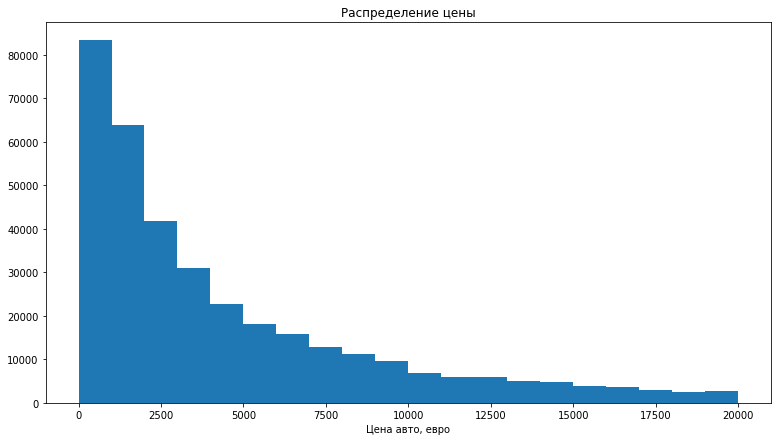

In [23]:
plt.figure(figsize=(13,7))
plt.hist(df['Price'], bins=20)
plt.title("Распределение цены")
plt.xlabel("Цена авто, евро")
plt.show()

C:\Users\mriva\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

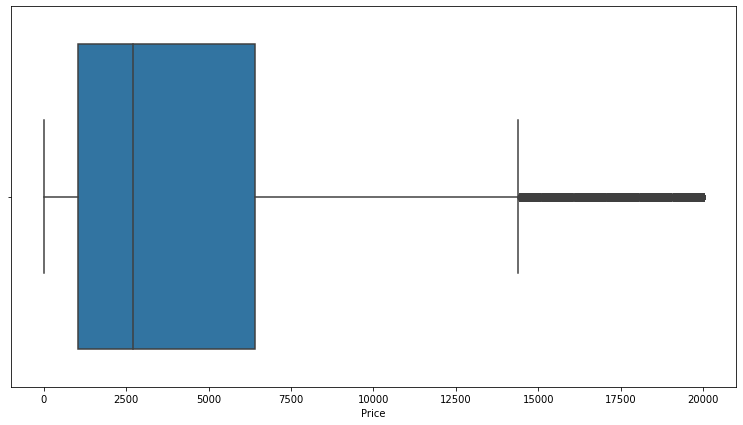

In [24]:
plt.figure(figsize=(13,7))
sns.boxplot(df['Price'])

На графиках можно отетливо увидеть Пуссоновское распределение. Граница правого уса заканчивается на 14525 тысячах евро, далее идут более дорогие машины. Необходимо посмотреть примеры таких машин и определиться являются ли их цены ошибками или они действительно так стоят. Также достаточно большое количество машин стоимостью от 0 до 500 евро. По ним также посмотрим данные более подробнее.

In [25]:
df[df['Price'] < 50]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,0,other,1990,other,0,corsa,150000,petrol,opel,no
59,1,suv,1994,manual,286,other,150000,other,sonstige_autos,no
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,0,other,2017,manual,0,golf,5000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354205,0,other,2000,manual,65,corsa,150000,other,opel,yes
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,no
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,no
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


In [26]:
df[df['Price'] == 0]['NotRepaired'].value_counts()

no     8767
yes    2005
Name: NotRepaired, dtype: int64

In [27]:
df[df['Price'] < 50]['NotRepaired'].value_counts()

no     10130
yes     2293
Name: NotRepaired, dtype: int64

Из анализа приведенных данных по низким ценам можно сделать следующие выводы (предположения):
1. По большей части до 50 евро продаются битые машины.
2. Очень большое количество данных, где цена авто = 0. Возможно люди просто хотят избавиться от старого ненужного авто, но возможно, что это ошибка заполнения данных. В связи с тем, что невозможно установить истину относительно таких значений, то авто с 0-й ценой лучше исключить из датасета.
3. Если предположить, что машина битая, то она может продаваться за такую цену, но целая машина точно не может стоить меньше хотя бы 100 евро. Поэтому небитые машины с ценой менее 100 евро также должны быть исключены из датасета.

Посмотрим на другой конец распределения - очень дорогие машины.

In [28]:
df[df['Price'] > 15000].head(30)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
179,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no
204,18400,wagon,2011,auto,313,5er,150000,gasoline,bmw,no
236,15700,sedan,2011,manual,170,golf,90000,gasoline,volkswagen,no
282,18700,coupe,2009,auto,213,mustang,80000,petrol,ford,no
287,16150,suv,2011,manual,150,tiguan,30000,petrol,volkswagen,no
313,16500,coupe,2007,manual,265,z_reihe,150000,petrol,bmw,no


Выведенные данные показали, что в диапазон цен свыше 15000 попали машины действительно дорогого сегмента, поэтому удаление выбросов с этой стороны не требуется.

In [29]:
df = df[df['Price'] != 0]
df = df.drop(df[(df['Price'] < 100) & (df['NotRepaired'] != 'no')].index)

Обработка аномалий по цене выполнена.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343040 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343040 non-null  int64 
 1   VehicleType       343040 non-null  object
 2   RegistrationYear  343040 non-null  int64 
 3   Gearbox           343040 non-null  object
 4   Power             343040 non-null  int64 
 5   Model             343040 non-null  object
 6   Kilometer         343040 non-null  int64 
 7   FuelType          343040 non-null  object
 8   Brand             343040 non-null  object
 9   NotRepaired       343040 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.8+ MB


### 1.3 Проверка на дубликаты

Проверим наш датасет на наличие полных дубликатов и при их нахождении избавимся от них.

In [31]:
df.duplicated().sum() # проверим на дубликаты

50028

Зафиксировано большое количество дубликатов, что говорит о том, что продается значительное количество похожих автомобилей. Уберем дубликаты, чтобы не переобучать модели.

In [32]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293012 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             293012 non-null  int64 
 1   VehicleType       293012 non-null  object
 2   RegistrationYear  293012 non-null  int64 
 3   Gearbox           293012 non-null  object
 4   Power             293012 non-null  int64 
 5   Model             293012 non-null  object
 6   Kilometer         293012 non-null  int64 
 7   FuelType          293012 non-null  object
 8   Brand             293012 non-null  object
 9   NotRepaired       293012 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.6+ MB


### 1.4 Проверка на мультиколлинеарность

Проверим корреляцию наших признаков между собой.

<AxesSubplot:>

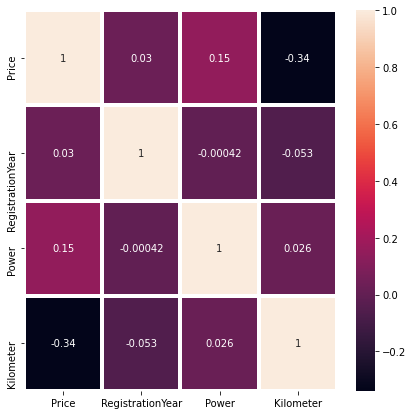

In [33]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(df.corr(), annot=True, linewidths=3, linecolor='white')

Цена незначительно зависит от года регистрации и мощности авто, обучающие признаки не коррелируют друг с другом, следовательно удаления признаков не требуется.

### 1.5 Подготовка датасета для обучения различных моделей

Проведем кодирование категориальных признаков. В дальнейшем будем использовать различные модели, в зависимости от модели необходимо применять различные типы кодирования. В случае линейной регрессии подойдет техника прямого кодирования (англ. One-Hot Encoding, OHE), а в случае деревьев и лесов - порядкового кодирования (ordinal encoding), поэтому далее будет подготовлено два набора данных для обоих видов кодирования. После кодирования необходимо будет сделать масштабирование числовых признаков. Также в случае ряда бустинговых моделей кодировка не требуется, поэтому будет подготовлен 3-й датасет без кодировки, но с масштабированием.

In [34]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# кодирование OHE
df_ohe = pd.get_dummies(df, drop_first=True, columns=cat_columns)
display(df_ohe.head(10))

# кодирование OE
encoder = OrdinalEncoder()
df_ord = df.copy()
df_ord[cat_columns] = encoder.fit_transform(df_ord[cat_columns])
display(df_ord.head(10))

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,480,1993,0,150000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,3.000,1993,1.000,0,116.000,150000,6.000,38.000,0.000
1,18300,2.000,2011,1.000,190,166.000,125000,2.000,1.000,1.000
2,9800,6.000,2004,0.000,163,117.000,125000,2.000,14.000,0.000
3,1500,5.000,2001,1.000,75,116.000,150000,6.000,38.000,0.000
4,3600,5.000,2008,1.000,69,101.000,90000,2.000,31.000,0.000
5,650,4.000,1995,1.000,102,11.000,150000,6.000,2.000,1.000
6,2200,1.000,2004,1.000,109,8.000,150000,6.000,25.000,0.000
8,14500,0.000,2014,1.000,125,60.000,30000,6.000,10.000,0.000
9,999,5.000,1998,1.000,101,116.000,150000,5.000,38.000,0.000
10,2000,4.000,2004,1.000,105,10.000,150000,6.000,19.000,0.000


In [35]:
# функция для деления датасетов на обучающую, и тестовую выборки
def split_func (df):
    target = df['Price']
    features = df.drop('Price', axis=1)
    
    features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) # разделили выборки в пропорции 2 к 8
    
    
    return features_train, features_test, target_train, target_test

In [36]:
# получим выборки для кодировки OHE
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = split_func(df_ohe)

In [37]:
# проверим полученные размерности
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)

(234409, 307)
(58603, 307)
(234409,)
(58603,)


In [38]:
# получим выборки для кодировки ord
features_train_ord, features_test_ord, target_train_ord, target_test_ord = split_func(df_ord)

# проверим полученные размерности
for i in [features_train_ord, features_test_ord, target_train_ord, target_test_ord]:
    print(i.shape)

(234409, 9)
(58603, 9)
(234409,)
(58603,)


In [39]:
# получим выборки без кодировки
features_train_no, features_test_no, target_train_no, target_test_no = split_func(df)

# проверим полученные размерности
for i in [features_train_no, features_test_no, target_train_no, target_test_no]:
    print(i.shape)

(234409, 9)
(58603, 9)
(234409,)
(58603,)


Проведем масштабирование признаков во всех выборках.

In [40]:
# подготовим функцию для масштабирования
def scal_func (features_train, features_test):
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    
    return features_train, features_test

In [41]:
# масштабируем данные с кодировкой ohe
features_train_ohe, features_test_ohe = scal_func (features_train_ohe, features_test_ohe)
features_train_ohe.describe() # проверим результат масштабирования

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,Model_1er,Model_200,Model_2_reihe,Model_300c,Model_3_reihe,Model_3er,Model_4_reihe,Model_500,Model_5_reihe,Model_5er,Model_601,Model_6_reihe,Model_6er,Model_7er,Model_80,Model_850,Model_90,Model_900,Model_9000,Model_911,Model_a1,Model_a2,Model_a3,Model_a4,Model_a5,Model_a6,Model_a8,Model_a_klasse,Model_accord,Model_agila,Model_alhambra,Model_almera,Model_altea,Model_amarok,Model_antara,Model_arosa,Model_astra,Model_auris,Model_avensis,Model_aveo,Model_aygo,Model_b_klasse,Model_b_max,Model_beetle,Model_berlingo,Model_bora,Model_boxster,Model_bravo,Model_c1,Model_c2,Model_c3,Model_c4,Model_c5,Model_c_klasse,Model_c_max,Model_c_reihe,Model_caddy,Model_calibra,Model_captiva,Model_carisma,Model_carnival,Model_cayenne,Model_cc,Model_ceed,Model_charade,Model_cherokee,Model_citigo,Model_civic,Model_cl,Model_clio,Model_clk,Model_clubman,Model_colt,Model_combo,Model_cooper,Model_cordoba,Model_corolla,Model_corsa,Model_cr_reihe,Model_croma,Model_crossfire,Model_cuore,Model_cx_reihe,Model_defender,Model_delta,Model_discovery,Model_doblo,Model_ducato,Model_duster,Model_e_klasse,Model_elefantino,Model_eos,Model_escort,Model_espace,Model_exeo,Model_fabia,Model_fiesta,Model_focus,Model_forester,Model_forfour,Model_fortwo,Model_fox,Model_freelander,Model_fusion,Model_g_klasse,Model_galant,Model_galaxy,Model_getz,Model_gl,Model_glk,Model_golf,Model_grand,Model_i3,Model_i_reihe,Model_ibiza,Model_impreza,Model_insignia,Model_jazz,Model_jetta,Model_jimny,Model_juke,Model_justy,Model_ka,Model_kadett,Model_kaefer,Model_kalina,Model_kalos,Model_kangoo,Model_kappa,Model_kuga,Model_laguna,Model_lancer,Model_lanos,Model_legacy,Model_leon,Model_lodgy,Model_logan,Model_lupo,Model_lybra,Model_m_klasse,Model_m_reihe,Model_materia,Model_matiz,Model_megane,Model_meriva,Model_micra,Model_mii,Model_modus,Model_mondeo,Model_move,Model_musa,Model_mustang,Model_mx_reihe,Model_navara,Model_niva,Model_note,Model_nubira,Model_octavia,Model_omega,Model_one,Model_other,Model_outlander,Model_pajero,Model_panda,Model_passat,Model_phaeton,Model_picanto,Model_polo,Model_primera,Model_ptcruiser,Model_punto,Model_q3,Model_q5,Model_q7,Model_qashqai,Model_r19,Model_range_rover,Model_range_rover_evoque,Model_range_rover_sport,Model_rangerover,Model_rav,Model_rio,Model_roadster,Model_roomster,Model_rx_reihe,Model_s60,Model_s_klasse,Model_s_max,Model_s_type,Model_samara,Model_sandero,Model_santa,Model_scenic,Model_scirocco,Model_seicento,Model_serie_1,Model_serie_2,Model_serie_3,Model_sharan,Model_signum,Model_sirion,Model_sl,Model_slk,Model_sorento,Model_spark,Model_spider,Model_sportage,Model_sprinter,Model_stilo,Model_superb,Model_swift,Model_terios,Model_tigra,Model_tiguan,Model_toledo,Model_touareg,Model_touran,Model_transit,Model_transporter,Model_tt,Model_tucson,Model_twingo,Model_up,Model_v40,Model_v50,Model_v60,Model_v70,Model_v_klasse,Model_vectra,Model_verso,Model_viano,Model_vito,Model_vivaro,Model_voyager,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,Brand_dacia,Brand_daewoo,Brand_daihatsu,Brand_fiat,Brand_ford,Brand_honda,Brand_hyundai,Brand_jaguar,Brand_jeep,Brand_kia,Brand_lada,Brand_lancia,Brand_land_rover,Brand_mazda,Brand_mercedes_benz,Brand_mini,Brand_mitsubishi,Brand_nissan,Brand_opel,Brand_peugeot,Brand_porsche,Brand_renault,Brand_rover,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
count,234409.000,234409.000,234409.000,234409.000,234409.000,234409.000,

In [42]:
# масштабируем данные с кодировкой ord
features_train_ord, features_test_ord = scal_func (features_train_ord, features_test_ord)

In [43]:
# масштабируем данные с кодировкой no
features_train_no, features_test_no = scal_func (features_train_no, features_test_no)

**ВЫВОД по 1 части**

На этапе подготовки данных проведена следующая работа:    
1. Исключены столбцы, не являющиеся обучающими признаками (*DateCrawled, RegistrationMonth, DateCreated, PostalCode, LastSeen, NumberOfPictures*).
2. Проведено заполнение пропусков **значением other** для: типа кузова, типа коробки передач, типа топлива, состояния ремонта.
3. Исключены нулевые цены, а также цены до 100 евро на небитые автомобили.
4. Проведено удаление дубликатов.
5. Проведена проверка на мультиколлинеарность.
6. Датасет разделен на обучающие, валидационные и тестовые выборки для трех кодировок: one-hot encoding, ordinal encoding, без кодировки.
7. Проведено масштабирование количественных данных.

## 2 Обучение моделей

Обучим следующие модели: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM.

### 2.1 Линейная регрессия

Произведем определение оптимальных параметров для линейной регрессии с помощью функционала GridSearchCV.

In [44]:
# создадим функцию для необходимого скора
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [88]:
'''model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
grid.fit(features_train_ohe, target_train_ohe)
print("RMSE линейной регрессии составляет ", grid.best_score_)'''

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  fit_intercept=True, normalize=True, score=-3232.000, total=  20.1s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.1s remaining:    0.0s


[CV]  fit_intercept=True, normalize=True, score=-8983178788918013.000, total=  22.3s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.5s remaining:    0.0s


[CV]  fit_intercept=True, normalize=True, score=-3252.209, total=  22.1s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s


[CV]  fit_intercept=True, normalize=True, score=-3248.117, total=  21.4s
[CV] fit_intercept=True, normalize=True ..............................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  fit_intercept=True, normalize=True, score=-3225.877, total=  21.1s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-3232.000, total=  20.6s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-3251.213, total=  22.9s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-3252.209, total=  24.2s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-3248.117, total=  20.7s
[CV] fit_intercept=True, normalize=False .............................
[CV]  fit_intercept=True, normalize=False, score=-3225.877, total=  21.1s
[CV] fit_intercept=False, normalize=True .............................
[CV]  fit_intercept=False, normalize=True, score=-3233.708, total=  20.1s
[CV] fit_intercept=False, normalize=True ................

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.0min finished


RMSE линейной регрессии составляет  -3241.8830506070713


In [89]:
'''print('Наилучшие подобранные параметры для линейной регрессии')
grid.best_params_'''

Наилучшие подобранные параметры для линейной регрессии


{'fit_intercept': True, 'normalize': False}

Наилучший RMSE 3241.883 при GridSearchCV получен для параметров: 'fit_intercept': True, 'normalize': False. **Код выше закоментирован, чтобы не выполнялся снова при перезапуске тетрадки.**

### 2.2 Решающее дерево

In [90]:
'''tree = DecisionTreeRegressor(random_state=12345)
    
tree_params = {'max_depth': range(1,15),
              'min_samples_split': range(2,7)}

tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, verbose=5, scoring=scorer)

tree_grid.fit(features_train_ord, target_train_ord)

print("RMSE для решающего дерева составляет ", tree_grid.best_score_)


print('Наилучшие подобранные параметры для решающего дерева')
print(tree_grid.best_params_)'''

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] max_depth=1, min_samples_split=2 ................................
[CV]  max_depth=1, min_samples_split=2, score=-3845.404, total=   0.1s
[CV] max_depth=1, min_samples_split=2 ................................
[CV]  max_depth=1, min_samples_split=2, score=-3873.029, total=   0.1s
[CV] max_depth=1, min_samples_split=2 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=1, min_samples_split=2, score=-3882.242, total=   0.1s
[CV] max_depth=1, min_samples_split=2 ................................
[CV]  max_depth=1, min_samples_split=2, score=-3841.325, total=   0.1s
[CV] max_depth=1, min_samples_split=2 ................................
[CV]  max_depth=1, min_samples_split=2, score=-3837.271, total=   0.1s
[CV] max_depth=1, min_samples_split=3 ................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=1, min_samples_split=3, score=-3845.404, total=   0.1s
[CV] max_depth=1, min_samples_split=3 ................................
[CV]  max_depth=1, min_samples_split=3, score=-3873.029, total=   0.1s
[CV] max_depth=1, min_samples_split=3 ................................
[CV]  max_depth=1, min_samples_split=3, score=-3882.242, total=   0.1s
[CV] max_depth=1, min_samples_split=3 ................................
[CV]  max_depth=1, min_samples_split=3, score=-3841.325, total=   0.1s
[CV] max_depth=1, min_samples_split=3 ................................
[CV]  max_depth=1, min_samples_split=3, score=-3837.271, total=   0.1s
[CV] max_depth=1, min_samples_split=4 ................................
[CV]  max_depth=1, min_samples_split=4, score=-3845.404, total=   0.1s
[CV] max_depth=1, min_samples_split=4 ................................
[CV]  max_depth=1, min_samples_split=4, score=-3873.029, total=   0.1s
[CV] max_depth=1, min_samples_split=4 ................................
[CV]  

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:  2.1min finished


RMSE для решающего дерева составляет  -2027.9202138537044
Наилучшие подобранные параметры для решающего дерева
{'max_depth': 14, 'min_samples_split': 6}


Наилучший RMSE 2027.922 при GridSearchCV получен для параметров: 'max_depth': 14, 'min_samples_split': 6.

### 2.3 Случайный лес

In [91]:
'''forest = RandomForestRegressor(random_state=12345)
    
forest_params = {'n_estimators': range(30, 81, 10),
                 'max_depth': range(1,12)}

forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, verbose=5, scoring=scorer)

forest_grid.fit(features_train_ord, target_train_ord)

print("RMSE для случайного леса составляет ", forest_grid.best_score_)


print('Наилучшие подобранные параметры для случайного леса')
print(forest_grid.best_params_)'''

Fitting 5 folds for each of 66 candidates, totalling 330 fits
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... max_depth=1, n_estimators=30, score=-3845.402, total=   1.3s
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .... max_depth=1, n_estimators=30, score=-3873.062, total=   1.4s
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] .... max_depth=1, n_estimators=30, score=-3882.236, total=   1.3s
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s


[CV] .... max_depth=1, n_estimators=30, score=-3841.333, total=   1.3s
[CV] max_depth=1, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.3s remaining:    0.0s


[CV] .... max_depth=1, n_estimators=30, score=-3837.242, total=   1.3s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] .... max_depth=1, n_estimators=40, score=-3845.402, total=   1.9s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] .... max_depth=1, n_estimators=40, score=-3873.067, total=   1.8s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] .... max_depth=1, n_estimators=40, score=-3882.237, total=   1.7s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] .... max_depth=1, n_estimators=40, score=-3841.337, total=   1.8s
[CV] max_depth=1, n_estimators=40 ....................................
[CV] .... max_depth=1, n_estimators=40, score=-3837.232, total=   1.9s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] .... max_depth=1, n_estimators=50, score=-3845.401, total=   2.3s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 330 out of 330 | elapsed: 61.1min finished


RMSE для случайного леса составляет  -1939.5265719231286
Наилучшие подобранные параметры для случайного леса
{'max_depth': 11, 'n_estimators': 70}


Наилучший RMSE 1939.527 при GridSearchCV для случайного леса получен для параметров: 'max_depth': 11, 'n_estimators': 70.

### 2.4 Light GBM

Т.к. одна из подзадач данного проекта - это самостоятельное изучение библиотеки Light GBM, сделаем небольшой конспект по ее особенностям.

Light GBM - это быстрая, распределенная, высокопроизводительная структура повышения градиента, основанная на алгоритме дерева решений, используемая для ранжирования, классификации и многих других задач машинного обучения.

Поскольку он основан на алгоритмах дерева решений, он разделяет лист дерева с наилучшим соответствием, тогда как другие алгоритмы повышения делят дерево по глубине или уровню, а не по листу. Таким образом, при выращивании на одном и том же листе в Light GBM, листовой алгоритм может уменьшить больше потерь, чем поуровневый алгоритм, и, следовательно, приводит к гораздо лучшей точности, что редко может быть достигнуто любым из существующих алгоритмов повышения.

Преимущества:
1. Быстрая скорость обучения и высокая эффективность: использует алгоритм на основе гистограммы, то есть он объединяет непрерывные значения признаков в дискретные ячейки, которые ускоряют процедуру обучения.
2. Более низкое использование памяти: заменяет непрерывные значения на дискретные ячейки, что приводит к снижению использования памяти.
3. Лучшая точность, чем у любого другого алгоритма усиления: создает гораздо более сложные деревья, следуя подходу с разбивкой по листам, а не по уровням, что является основным фактором в достижении более высокой точности.
4. Совместимость с большими наборами данных: способен одинаково хорошо работать с большими наборами данных при значительном сокращении времени обучения по сравнению с XGBOOST.

Важные параметры:
- n_estimators - количество деревьев для бустинга;
- max_depth - глубина деревьев, по умолчанию используется неопредёленное значение, поскольку механизм по умолчанию для управления сложностью деревьев заключается в использовании конечного количества узлов;
- num_leaves: количество узлов. Наличие большого количества листьев улучшит точность, но также приведет к переообучению.
- max_bin: максимальное количество ячеек, в которых хранятся значения признаков. Меньше max_bin уменьшает переообучение.
- lambda_l1, а также lambda_l2: контролирует регуляризацию L1 и L2.
- learning_rate: скорость обучения.

Несмотря на то, что библиотеки Light GBM и CatBoost не требуют кодирования нечисловых признаков, такие признаки рекомендуется перевести в тип category.

In [45]:
def obj_to_cat (df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            df[c] = df[c].astype('category')

In [46]:
obj_to_cat(features_train_no)
features_train_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234409 entries, 209881 to 254035
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       234409 non-null  category
 1   RegistrationYear  234409 non-null  float64 
 2   Gearbox           234409 non-null  category
 3   Power             234409 non-null  float64 
 4   Model             234409 non-null  category
 5   Kilometer         234409 non-null  float64 
 6   FuelType          234409 non-null  category
 7   Brand             234409 non-null  category
 8   NotRepaired       234409 non-null  category
dtypes: category(6), float64(3)
memory usage: 8.7 MB


In [47]:
obj_to_cat(features_test_no)
features_test_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58603 entries, 159927 to 189770
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       58603 non-null  category
 1   RegistrationYear  58603 non-null  float64 
 2   Gearbox           58603 non-null  category
 3   Power             58603 non-null  float64 
 4   Model             58603 non-null  category
 5   Kilometer         58603 non-null  float64 
 6   FuelType          58603 non-null  category
 7   Brand             58603 non-null  category
 8   NotRepaired       58603 non-null  category
dtypes: category(6), float64(3)
memory usage: 2.2 MB


Попробуем подобрать наиболее оптимальные параметры.

In [95]:
'''cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [50, 100, 500],
              'num_leaves': [21, 31, 41], 
              'learning_rate':[0.01, .04, 0.06]}

g_grid = GridSearchCV(gbm, g_params,
                         cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train_no, target_train_no)

print("RMSE для LGBM составляет ", g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM')
print(g_grid.best_params_)'''

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-3388.211, total=   4.6s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-3429.335, total=   5.9s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-3417.696, total=   4.8s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-3390.146, total=   5.6s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=21 ..............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.0s remaining:    0.0s


[CV]  learning_rate=0.01, n_estimators=50, num_leaves=21, score=-3378.405, total=   5.0s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-3338.104, total=   5.3s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-3377.528, total=   5.3s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-3366.250, total=   5.6s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-3339.233, total=   5.7s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=31 ..............
[CV]  learning_rate=0.01, n_estimators=50, num_leaves=31, score=-3326.752, total=   6.2s
[CV] learning_rate=0.01, n_estimators=50, num_leaves=41 ..............
[CV]  learning_rate=0.01, n_estimators=5

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 56.5min finished


RMSE для LGBM составляет  -1684.875750492549
Наилучшие подобранные параметры для LGBM
{'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41}


Наилучший RMSE 1684.875 при GridSearchCV для LGBM получен для параметров: 'learning_rate': 0.06, 'n_estimators': 500, 'num_leaves': 41.

### 2.5 CatBoost

Проведем также поиск оптимальных параметров для CatBoostRegressor.

In [96]:
'''cbr = CatBoostRegressor(cat_features = cat_feat, loss_function="RMSE")

grid = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}

cbr_grid = GridSearchCV(cbr, grid,
                         cv=5, verbose=5, scoring=scorer)

cbr_grid.fit(features_train_no, target_train_no)

print("RMSE для CBR составляет ", cbr_grid.best_score_)


print('Наилучшие подобранные параметры для CBR')
print(cbr_grid.best_params_)'''

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] iterations=150, learning_rate=0.03 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 4492.6022046	total: 310ms	remaining: 46.2s
1:	learn: 4409.7672513	total: 609ms	remaining: 45.1s
2:	learn: 4328.1735482	total: 916ms	remaining: 44.9s
3:	learn: 4250.7209016	total: 1.21s	remaining: 44.2s
4:	learn: 4175.2876492	total: 1.51s	remaining: 43.7s
5:	learn: 4102.8142817	total: 1.81s	remaining: 43.3s
6:	learn: 4032.2732649	total: 2.1s	remaining: 43s
7:	learn: 3964.9007458	total: 2.31s	remaining: 41.1s
8:	learn: 3899.8968022	total: 2.61s	remaining: 40.9s
9:	learn: 3837.9086917	total: 2.91s	remaining: 40.7s
10:	learn: 3776.8684288	total: 3.2s	remaining: 40.5s
11:	learn: 3720.7497225	total: 3.5s	remaining: 40.3s
12:	learn: 3665.7027459	total: 3.8s	remaining: 40s
13:	learn: 3612.3895441	total: 4.01s	remaining: 38.9s
14:	learn: 3561.5692232	total: 4.3s	remaining: 38.7s
15:	learn: 3511.7060068	total: 4.6s	remaining: 38.5s
16:	learn: 3464.5870893	total: 4.9s	remaining: 38.3s
17:	learn: 3418.9021181	total: 5.2s	remaining: 38.1s
18:	learn: 3373.6070624	total: 5.5s	remaining: 37.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.7s remaining:    0.0s


0:	learn: 4482.2445217	total: 217ms	remaining: 32.3s
1:	learn: 4399.3198133	total: 429ms	remaining: 31.8s
2:	learn: 4318.4533647	total: 817ms	remaining: 40s
3:	learn: 4242.1080839	total: 1.02s	remaining: 37.4s
4:	learn: 4165.8180654	total: 1.32s	remaining: 38.3s
5:	learn: 4093.9588577	total: 1.62s	remaining: 38.9s
6:	learn: 4023.7613619	total: 1.91s	remaining: 39.1s
7:	learn: 3957.0622555	total: 2.21s	remaining: 39.3s
8:	learn: 3892.3604667	total: 2.42s	remaining: 37.9s
9:	learn: 3831.1163446	total: 2.71s	remaining: 38s
10:	learn: 3771.6248890	total: 3.01s	remaining: 38s
11:	learn: 3713.7365809	total: 3.31s	remaining: 38.1s
12:	learn: 3659.4691258	total: 3.6s	remaining: 38s
13:	learn: 3606.2872302	total: 3.82s	remaining: 37.1s
14:	learn: 3555.8856967	total: 4.11s	remaining: 37s
15:	learn: 3506.7124055	total: 4.41s	remaining: 36.9s
16:	learn: 3459.3720025	total: 4.71s	remaining: 36.8s
17:	learn: 3413.7748876	total: 5s	remaining: 36.7s
18:	learn: 3368.5597247	total: 5.22s	remaining: 36s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


0:	learn: 4487.0945977	total: 281ms	remaining: 41.8s
1:	learn: 4404.5637364	total: 577ms	remaining: 42.7s
2:	learn: 4322.7367345	total: 882ms	remaining: 43.2s
3:	learn: 4244.3124623	total: 1.18s	remaining: 43s
4:	learn: 4168.8678757	total: 1.48s	remaining: 42.8s
5:	learn: 4095.8212526	total: 1.69s	remaining: 40.5s
6:	learn: 4025.2123721	total: 1.98s	remaining: 40.5s
7:	learn: 3957.8744057	total: 2.27s	remaining: 40.4s
8:	learn: 3893.1418728	total: 2.57s	remaining: 40.3s
9:	learn: 3831.2018663	total: 2.78s	remaining: 39s
10:	learn: 3771.3229483	total: 3.09s	remaining: 39.1s
11:	learn: 3713.7243404	total: 3.38s	remaining: 38.8s
12:	learn: 3657.7396778	total: 3.67s	remaining: 38.7s
13:	learn: 3604.6807810	total: 3.97s	remaining: 38.6s
14:	learn: 3552.8885857	total: 4.18s	remaining: 37.6s
15:	learn: 3503.2942624	total: 4.47s	remaining: 37.5s
16:	learn: 3456.3528198	total: 4.77s	remaining: 37.3s
17:	learn: 3412.5277654	total: 5.07s	remaining: 37.2s
18:	learn: 3367.6417584	total: 5.36s	remai

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


0:	learn: 4492.5623331	total: 266ms	remaining: 39.6s
1:	learn: 4409.6712687	total: 478ms	remaining: 35.4s
2:	learn: 4328.4438917	total: 866ms	remaining: 42.4s
3:	learn: 4250.0311824	total: 1.07s	remaining: 39.3s
4:	learn: 4175.0780740	total: 1.37s	remaining: 39.9s
5:	learn: 4102.4675587	total: 1.67s	remaining: 40.1s
6:	learn: 4032.9957642	total: 1.97s	remaining: 40.2s
7:	learn: 3965.1661156	total: 2.26s	remaining: 40.2s
8:	learn: 3900.1429584	total: 2.56s	remaining: 40.1s
9:	learn: 3836.1954372	total: 2.77s	remaining: 38.7s
10:	learn: 3776.3150054	total: 3.06s	remaining: 38.7s
11:	learn: 3718.8220788	total: 3.36s	remaining: 38.6s
12:	learn: 3662.6912063	total: 3.65s	remaining: 38.5s
13:	learn: 3608.5293931	total: 3.86s	remaining: 37.5s
14:	learn: 3557.5986678	total: 4.16s	remaining: 37.4s
15:	learn: 3508.8841223	total: 4.45s	remaining: 37.3s
16:	learn: 3461.4190231	total: 4.75s	remaining: 37.2s
17:	learn: 3416.3510706	total: 4.97s	remaining: 36.4s
18:	learn: 3371.1250568	total: 5.26s	r

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.9min remaining:    0.0s


0:	learn: 4494.0879468	total: 287ms	remaining: 42.7s
1:	learn: 4408.8937609	total: 586ms	remaining: 43.4s
2:	learn: 4328.0106016	total: 885ms	remaining: 43.4s
3:	learn: 4250.6210530	total: 1.18s	remaining: 43.1s
4:	learn: 4175.1137460	total: 1.39s	remaining: 40.3s
5:	learn: 4103.1560334	total: 1.69s	remaining: 40.4s
6:	learn: 4033.1567084	total: 1.99s	remaining: 40.6s
7:	learn: 3964.1481634	total: 2.28s	remaining: 40.5s
8:	learn: 3899.8323700	total: 2.58s	remaining: 40.4s
9:	learn: 3836.7779696	total: 2.78s	remaining: 39s
10:	learn: 3777.1714118	total: 3.08s	remaining: 38.9s
11:	learn: 3719.0456726	total: 3.38s	remaining: 38.9s
12:	learn: 3663.2449714	total: 3.67s	remaining: 38.7s
13:	learn: 3610.1836513	total: 3.88s	remaining: 37.7s
14:	learn: 3559.3343986	total: 4.18s	remaining: 37.6s
15:	learn: 3509.8534531	total: 4.47s	remaining: 37.5s
16:	learn: 3461.5489463	total: 4.77s	remaining: 37.3s
17:	learn: 3416.9787997	total: 5.07s	remaining: 37.2s
18:	learn: 3372.1512349	total: 5.37s	rem

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 84.5min finished


0:	learn: 3294.2633727	total: 814ms	remaining: 6m 46s
1:	learn: 2722.8142334	total: 1.61s	remaining: 6m 42s
2:	learn: 2390.5876094	total: 2.42s	remaining: 6m 41s
3:	learn: 2227.2079350	total: 3.22s	remaining: 6m 39s
4:	learn: 2157.8992187	total: 4.01s	remaining: 6m 36s
5:	learn: 2105.7782690	total: 4.71s	remaining: 6m 27s
6:	learn: 2068.3888016	total: 5.41s	remaining: 6m 21s
7:	learn: 2051.4090452	total: 6.1s	remaining: 6m 15s
8:	learn: 2027.2769709	total: 6.61s	remaining: 6m
9:	learn: 2003.0224714	total: 7.31s	remaining: 5m 58s
10:	learn: 1989.5096310	total: 8.11s	remaining: 6m
11:	learn: 1975.8066874	total: 8.82s	remaining: 5m 58s
12:	learn: 1965.7825766	total: 9.51s	remaining: 5m 56s
13:	learn: 1952.9768412	total: 10.3s	remaining: 5m 57s
14:	learn: 1937.5348384	total: 11s	remaining: 5m 55s
15:	learn: 1930.1848057	total: 11.8s	remaining: 5m 56s
16:	learn: 1921.4985062	total: 12.5s	remaining: 5m 54s
17:	learn: 1918.2956028	total: 13.2s	remaining: 5m 52s
18:	learn: 1912.7090759	total: 

Наилучший RMSE 1724.287 при GridSearchCV для CBR получен для параметров: 'iterations': 500, 'learning_rate': 0.5. И опять метрика чуть хуже.

**ВЫВОД по 2 части**

Обучено и подобраны гиперпараметры для 5 различных моделей: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM. Для всех моделей была применена кросс-валидация, вшитая в метод GridSearchCV.

Наихудшим результатом (2805 евро) обладает модель линейной регрессии, наилучший результат был получен с помощью модели Light GBM (1673 евро), сравнительно недалеко от него находится результат модели CatBoostRegressor (1710 евро). Исходя из этого, можно заключить, что бустинговые модели лучше справились с минимизацией поставленной метрики. В следующем разделе каждая модель с найденными гиперпараметрами будет обучена на трейне и протестирована на тестовой выборке.

## 3 Анализ моделей

In [48]:
# создадим таблицу для хранения результатов
d = {'model': [], 'RMSE':[], 'fit_time': [], 'predict_time':[]}
results = pd.DataFrame(data=d)
results

,model,RMSE,fit_time,predict_time


In [49]:
# создадим функцию для добавления результатов в таблицу
def model_res(model_name, model, features_train, target_train, features_test, target_test):
    rmse, fit_time, pred_time = ml(model, features_train, target_train, features_test, target_test)
    results.loc[len(results)] = [model_name, rmse, fit_time, pred_time]
    if len(results) > 0: # исключим дублировании при неоднократном выполнении функции для одной и той же модели
        results.drop_duplicates(inplace=True)

In [50]:
# cоздадим функцию для расчета необходимых параметров
def ml (model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    
    fit_time = stop_fit_time - start_fit_time
    
    start_predict_time = time.time()
    predictions = model.predict(features_test)
    stop_predict_time = time.time()
    
    pred_time = stop_predict_time - start_predict_time
    
    rmse = mean_squared_error(target_test, predictions)**0.5
    
    return rmse, fit_time, pred_time

In [51]:
# линейная регрессия
lr = LinearRegression(fit_intercept=True, normalize=False)
model_res('LinearRegression', lr,  features_train_ohe, target_train_ohe,
          features_test_ohe, target_test_ohe)

In [52]:
# решающее дерево
dt = DecisionTreeRegressor(max_depth=14, min_samples_split=6, random_state=12345)
model_res('DecisionTreeRegressor', dt,  features_train_ord, target_train_ord,
          features_test_ord, target_test_ord)

In [53]:
# случайный лес
rf = RandomForestRegressor(max_depth=11, n_estimators=80, random_state=12345)
model_res('RandomForestRegressor', rf,  features_train_ord, target_train_ord,
          features_test_ord, target_test_ord)

In [54]:
# Light GBM
lgbm = LGBMRegressor(learning_rate=0.06, n_estimators=500, num_leaves=41, random_state=12345)
model_res('LGBMRegressor', lgbm,  features_train_no, target_train_no,
          features_test_no, target_test_no)

In [56]:
# CatBoost
cat_feat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cb = CatBoostRegressor(cat_features = cat_feat, 
                         loss_function="RMSE",
                         learning_rate=0.5, 
                         iterations=500,
                         random_state=12345)
model_res('CatBoostRegressor', cb,  features_train_no, target_train_no,
          features_test_no, target_test_no)

0:	learn: 3291.2250757	total: 619ms	remaining: 5m 8s
1:	learn: 2726.9151250	total: 828ms	remaining: 3m 26s
2:	learn: 2419.0977309	total: 1.15s	remaining: 3m 10s
3:	learn: 2258.2546968	total: 1.47s	remaining: 3m 1s
4:	learn: 2179.1018733	total: 1.61s	remaining: 2m 39s
5:	learn: 2131.7065539	total: 1.87s	remaining: 2m 34s
6:	learn: 2101.3103716	total: 2.08s	remaining: 2m 26s
7:	learn: 2068.6387199	total: 2.3s	remaining: 2m 21s
8:	learn: 2048.5424084	total: 2.52s	remaining: 2m 17s
9:	learn: 2026.6371053	total: 2.75s	remaining: 2m 14s
10:	learn: 2014.9691749	total: 2.97s	remaining: 2m 12s
11:	learn: 2000.1720795	total: 3.18s	remaining: 2m 9s
12:	learn: 1981.2396968	total: 3.39s	remaining: 2m 7s
13:	learn: 1968.2985299	total: 3.56s	remaining: 2m 3s
14:	learn: 1955.2776315	total: 3.74s	remaining: 2m
15:	learn: 1950.9279477	total: 3.98s	remaining: 2m
16:	learn: 1943.8771478	total: 4.11s	remaining: 1m 56s
17:	learn: 1929.7251132	total: 4.31s	remaining: 1m 55s
18:	learn: 1924.6002156	total: 4.4

150:	learn: 1697.7442205	total: 28.8s	remaining: 1m 6s
151:	learn: 1697.6287732	total: 29s	remaining: 1m 6s
152:	learn: 1697.1570400	total: 29.2s	remaining: 1m 6s
153:	learn: 1696.3869585	total: 29.4s	remaining: 1m 5s
154:	learn: 1695.8551547	total: 29.5s	remaining: 1m 5s
155:	learn: 1695.6757374	total: 29.7s	remaining: 1m 5s
156:	learn: 1695.2161501	total: 29.9s	remaining: 1m 5s
157:	learn: 1694.7760282	total: 30.1s	remaining: 1m 5s
158:	learn: 1694.0143738	total: 30.3s	remaining: 1m 4s
159:	learn: 1693.3366238	total: 30.4s	remaining: 1m 4s
160:	learn: 1692.3999673	total: 30.6s	remaining: 1m 4s
161:	learn: 1691.9258897	total: 30.8s	remaining: 1m 4s
162:	learn: 1691.6559121	total: 31s	remaining: 1m 4s
163:	learn: 1691.4897637	total: 31.2s	remaining: 1m 3s
164:	learn: 1690.6440072	total: 31.4s	remaining: 1m 3s
165:	learn: 1689.9406548	total: 31.6s	remaining: 1m 3s
166:	learn: 1689.8372399	total: 31.7s	remaining: 1m 3s
167:	learn: 1689.7631597	total: 31.9s	remaining: 1m 2s
168:	learn: 16

302:	learn: 1637.1618060	total: 57s	remaining: 37.1s
303:	learn: 1636.8445654	total: 57.2s	remaining: 36.9s
304:	learn: 1636.5488128	total: 57.4s	remaining: 36.7s
305:	learn: 1636.3750117	total: 57.6s	remaining: 36.5s
306:	learn: 1636.2124169	total: 57.7s	remaining: 36.3s
307:	learn: 1636.1300341	total: 57.9s	remaining: 36.1s
308:	learn: 1635.8148965	total: 58.1s	remaining: 35.9s
309:	learn: 1635.5160226	total: 58.3s	remaining: 35.7s
310:	learn: 1635.0220583	total: 58.5s	remaining: 35.5s
311:	learn: 1634.7923284	total: 58.7s	remaining: 35.4s
312:	learn: 1634.5662524	total: 58.9s	remaining: 35.2s
313:	learn: 1634.4398515	total: 59.1s	remaining: 35s
314:	learn: 1634.2643470	total: 59.4s	remaining: 34.9s
315:	learn: 1633.8673941	total: 59.5s	remaining: 34.7s
316:	learn: 1633.8243838	total: 59.8s	remaining: 34.5s
317:	learn: 1633.7007736	total: 1m	remaining: 34.4s
318:	learn: 1633.3914579	total: 1m	remaining: 34.2s
319:	learn: 1632.9170537	total: 1m	remaining: 34s
320:	learn: 1632.7702277	

451:	learn: 1599.3144805	total: 1m 25s	remaining: 9.04s
452:	learn: 1599.0606034	total: 1m 25s	remaining: 8.85s
453:	learn: 1598.8472150	total: 1m 25s	remaining: 8.66s
454:	learn: 1598.4586027	total: 1m 25s	remaining: 8.47s
455:	learn: 1598.2497041	total: 1m 25s	remaining: 8.27s
456:	learn: 1598.0143657	total: 1m 25s	remaining: 8.08s
457:	learn: 1597.8866523	total: 1m 26s	remaining: 7.89s
458:	learn: 1597.7227296	total: 1m 26s	remaining: 7.7s
459:	learn: 1597.5823037	total: 1m 26s	remaining: 7.51s
460:	learn: 1597.2722531	total: 1m 26s	remaining: 7.33s
461:	learn: 1597.0066770	total: 1m 26s	remaining: 7.14s
462:	learn: 1596.9421578	total: 1m 26s	remaining: 6.95s
463:	learn: 1596.7726820	total: 1m 27s	remaining: 6.76s
464:	learn: 1596.4052453	total: 1m 27s	remaining: 6.57s
465:	learn: 1596.3370921	total: 1m 27s	remaining: 6.38s
466:	learn: 1596.2596963	total: 1m 27s	remaining: 6.19s
467:	learn: 1595.9738674	total: 1m 27s	remaining: 6s
468:	learn: 1595.6745649	total: 1m 28s	remaining: 5.

In [57]:
results['fit-predict_time'] = results['fit_time'] + results['predict_time']
results

,model,RMSE,fit_time,predict_time,fit-predict_time
0,LinearRegression,3239.176,12.584,0.120,12.704
1,DecisionTreeRegressor,2021.790,0.715,0.020,0.735
2,RandomForestRegressor,1939.823,32.446,0.503,32.949
3,LGBMRegressor,1686.449,4.714,0.582,5.297
4,CatBoostRegressor,1715.893,99.334,0.179,99.513


**ВЫВОД по 3 части**

Проведенный анализ с проверкой моделей на тестовой выборке показал, что наилучшую метрику RMSE возможно получить с применением библиотеки Light GBM. Близкое к данной метрике значение дала библиотека CatBoost, но при этом она значительно дольше обучается, но быстрее предсказывает. Если сравнить суммарное время на fit-predict, то модель LGBMRegressor выполнила поставленную задачу в 6 раз быстрее, чем CatBoostRegressor и с лучшим значением метркии RMSE.
    
Проведенное тестирование еще раз доказало, что бустинговые модели дают значительно лучший скор, чем линейная регрессия, дерево решений и случайный лес.